# Central Line UNet


This noteboook contains all the code neccesary to train the UNet used in this project for ultrasound image segmentation.

---

# Define user parameters

In [8]:
import numpy as np

#Paths
output_dir = r"D:\CISC881Project\usSegmentationOutPut"
aigt_repo_path = r"C:\repos\aigt"

#Notebook name
notebook_name = 'Central_Line_UNet'

#Sequences to be used for validation and testing; the rest is for training
test_idx = [15,16,17,18]

# Learning parameters
ultrasound_size = 128 #Dimensions of the US images used
num_epochs = 8 #Number of times to adjust weights following use of a batch of data
batch_size = 128 #Number of images to feed in for each epoch
max_learning_rate = 0.02 #Used in defining Adam parameters
min_learning_rate = 0.00001 #Used to generate learning_rate_decay
regularization_rate = 0.0001 #Used in uNet definition; L1 bias regulation
filter_multiplier = 8 #used in UNet definition
class_weights = np.array([0.1, 0.9]) #Weights for weighted categorical cross entropy
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs #the rate at which the learning rate decays; adam parameter

# Training data augmentation parameters for segmentation batch generation
max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

acceptable_margin_mm = 1.0 #For evaluation of segmentation
mm_per_pixel = 1.0

#Define roc thresholds
roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

---

# Imports
## Python packages

In [3]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split

## Libraries in aigt repository

In [4]:
sys.path.append(aigt_repo_path)
sys.path.append(os.path.join(aigt_repo_path, "UltrasoundSegmentation"))

import ultrasound_batch_generator as generator
import evaluation_metrics
import Models.segmentation_unet as unet
import utils

NameError: name 'aigt_repo_path' is not defined

---

# Read in data

In [9]:
#Read the US image and segmentations paths into lists
data_input_dir = r"C:\\Users\\cbarr\\OneDrive - Queen's University\\Grad School\\Courses\\CISC 881\\Project\\Data\\PilotNpData"
seg_files = list(sorted(Path(data_input_dir).glob("*_segmentation.npy")))
us_files = list(sorted(Path(data_input_dir).glob("*_ultrasound.npy")))

#Go through all file paths in both arrays and append to list
seg_data_by_seq = []
us_data_by_seq = []
for i in range(len(seg_files)):

    #Load the current files as 3D numpy arrays
    seg_np = np.load(os.path.abspath(seg_files[i]))
    us_np = np.load(os.path.abspath(us_files[i]))
    
    #Normalize and add channel dimension
    seg_np = seg_np[...,np.newaxis] / 255
    us_np = us_np[...,np.newaxis] / 255
    
    #Append to the collector lists.
    seg_data_by_seq.append(seg_np.transpose(2,1,0,3))
    us_data_by_seq.append(us_np.transpose(2,1,0,3))

#Verify that the total number of segmentation images matches the total number of us images.
for idx in range(len(seg_data_by_seq)):
    if len(seg_np[idx][0]) != len(us_np[idx][0]):
        print("Data Problem: Dataset {} has {} ultrasounds and {} segmentations". format(
            idx, len(seg_np[idx][0]), len(seg_np[idx][0])))

C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS01-20200210-132740_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS01-20200210-133541_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS01-20200210-134522_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS01-20200210-135109_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS01-20200210-135709_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS02-20200210-152131_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\PilotNpData\MS02-20200210-152827_segmentation.npy
C:\Users\cbarr\OneDrive - Queen's Univers

---

# Divide data into training, validation and testing

In [10]:
#Create lists of indices for training and validation sets
trainAndVal_idx = list(range(len(seg_data_by_seq)))
trainAndVal_idx = [x for x in trainAndVal_idx if x not in test_idx] #Remove IDs

#Extract and concatenate the segmentations for train / test / val
seg_trainAndVal = np.concatenate(np.take(seg_data_by_seq, trainAndVal_idx), axis=0)
seg_test = np.concatenate(np.take(seg_data_by_seq, test_idx), axis=0)

#Extract and concatenate the ultrasound images for train / test / val
us_trainAndVal = np.concatenate(np.take(us_data_by_seq, trainAndVal_idx), axis=0)
us_test = np.concatenate(np.take(us_data_by_seq, test_idx), axis=0)

#Extract training and validation sets from trainAndVal using 80/20 split
us_train, us_val, seg_train, seg_val = train_test_split(us_trainAndVal, seg_trainAndVal, test_size=0.2, random_state=2)

C:\repos\dlenv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
print("Trained on {} images, validated on {} images, tested on {} images.".format(us_train.shape[0],
                                                                                 us_val.shape[0],
                                                                                 us_test.shape[0]))

Trained on 15588 images, validated on 3897 images, tested on 5041 images.


# Setup variables for running UNet

In [12]:
from tensorflow.keras import backend as K

def IoU_loss(y_true,y_pred):
    smooth = 1e-12
    # author = Vladimir Iglovikov
    intersection = K.sum(y_true[:,:,:,1] * y_pred[:,:,:,1])#,axis=[1,2,3,4])
    sum_ = K.sum(y_true[:,:,:,1] + y_pred[:,:,:,1])#,axis=[1,2,3,4])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(1-jac)


def IoU(y_true,y_pred):
    # author = Vladimir Iglovikov
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred[:,:,:,1], 0, 1))

    intersection = K.sum(y_true[:,:,:,1] * y_pred_pos)#,axis=[1,2,3,4])
    sum_ = K.sum(y_true[:,:,:,1] + y_pred[:,:,:,1])#,axis=[1,2,3,4])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [8]:
#Convert validation categorical data to onehot dictated by the number of classes
seg_val_onehot = tf.keras.utils.to_categorical(seg_val, 2)
seg_train_onehot = tf.keras.utils.to_categorical(seg_train, 2)

#Get the model object from the aigt unet
model = unet.segmentation_unet(ultrasound_size, 2, filter_multiplier, regularization_rate)

# loss=unet.weighted_categorical_crossentropy(class_weights), #weighted categorical cross entropy

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
    loss=IoU_loss,
    metrics=[IoU]
)
#Initialize the training generator
training_generator = generator.UltrasoundSegmentationBatchGenerator(
    us_train,
    seg_train[:, :, :, 0],
    batch_size,
    (ultrasound_size, ultrasound_size),
    max_shift_factor=max_shift_factor,
    min_zoom_factor=min_zoom_factor,
    max_zoom_factor=max_zoom_factor,
    max_rotation_angle=max_rotation_angle
)

#Create a new timestamp for save files
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   100         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 18)   1638        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 26)   4238        conv2d_1[0][0]                   
______________________________________________________________________________________________

# Run the UNet and record results

In [9]:
#
training_time_start = datetime.datetime.now()

'''
training_log = model.fit_generator(
    training_generator,
    validation_data=(us_val, seg_val),
    epochs=8,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, )
    ])
'''
training_log = model.fit(us_train,seg_train_onehot,batch_size=128,validation_data=(us_val, seg_val_onehot),
    epochs=40,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, )
    ])
training_time_stop = datetime.datetime.now()

#Print training time
print("  Training time: {}".format(training_time_stop-training_time_start))

Train on 14732 samples, validate on 3683 samples
Epoch 1/40
14732/14732 [==============================] - 19s 1ms/sample - loss: 0.8271 - IoU: 0.1773 - val_loss: 0.8350 - val_IoU: 0.1693
Epoch 2/40
14732/14732 [==============================] - 9s 607us/sample - loss: 0.8364 - IoU: 0.1682 - val_loss: 0.8512 - val_IoU: 0.1532
Epoch 3/40
14732/14732 [==============================] - 9s 611us/sample - loss: 0.7221 - IoU: 0.2832 - val_loss: 0.8918 - val_IoU: 0.1122
Epoch 4/40
14732/14732 [==============================] - 9s 608us/sample - loss: 0.6929 - IoU: 0.3108 - val_loss: 0.7650 - val_IoU: 0.2393
Epoch 5/40
14732/14732 [==============================] - 9s 608us/sample - loss: 0.6519 - IoU: 0.3525 - val_loss: 0.6755 - val_IoU: 0.3288
Epoch 6/40
14732/14732 [==============================] - 9s 613us/sample - loss: 0.6321 - IoU: 0.3712 - val_loss: 0.7227 - val_IoU: 0.2814
Epoch 7/40
14732/14732 [==============================] - 9s 607us/sample - loss: 0.5939 - IoU: 0.4101 - val_los

In [10]:
# Archive trained model with unique filename based on notebook name and timestamp
model_file_name = notebook_name + "_fold_2_" + save_timestamp
model_fullname = os.path.join(output_dir, model_file_name)
model.save(model_fullname)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\CISC881Project\usSegmentationOutPut\Central_Line_UNet_fold_2_2020-12-04_19-14-59\assets


In [ ]:
# Plot training loss and metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(training_log.history['loss'], 'bo--')
axes[0].plot(training_log.history['val_loss'], 'ro-')
axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
axes[0].legend(['Training loss', 'Validation loss'])

axes[1].plot(training_log.history['IoU'], 'bo--')
axes[1].plot(training_log.history['val_IoU'], 'ro-')
axes[1].set(xlabel='Epochs (n)', ylabel='IoU')
axes[1].legend(['Training accuracy', 'Validation accuracy'])

fig.tight_layout()

# Predict on validation data
y_pred_val  = model.predict(us_val)

# Saving predictions for further evaluation
val_prediction_filename = save_timestamp + "_prediction.npy"
val_prediction_fullname = os.path.join(output_dir, val_prediction_filename)
np.save(val_prediction_fullname, y_pred_val)

# Validation results
vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_val, seg_val, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
val_best_metrics    = vali_metrics_dicts[vali_best_threshold_index]
val_auroc          = vali_area
val_best_threshold  = roc_thresholds[vali_best_threshold_index]

In [ ]:
def plotTrainingStats(training_history):
    # Plot the loss function
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(training_history.history['loss'], 'r', label='train')
    ax.plot(training_history.history['val_loss'], 'b' ,label='val')
    ax.set_title("Loss VS Epoch Number")
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Loss', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)

    # Plot the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(training_history.history['IoU'], 'r', label='train')
    ax.plot(training_history.history['val_IoU'], 'b' ,label='val')
    ax.set_title("IoU VS Epoch Number")
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'IoU', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)

In [ ]:
# Arrange results in tables

metric_labels = [
    "Validation AUROC",
    "Validationbest thresh",
    "Validation best TP",
    "Validation best FP",
    "Validation best recall",
    "Validation best precis",
]

results_df = pd.DataFrame(columns = metric_labels)


results_df.loc[0] = [
    val_auroc,
    val_best_threshold,
    val_best_metrics[evaluation_metrics.TRUE_POSITIVE_RATE],
    val_best_metrics[evaluation_metrics.FALSE_POSITIVE_RATE],
    val_best_metrics[evaluation_metrics.RECALL],
    val_best_metrics[evaluation_metrics.PRECISION]
]

display(results_df)

# Testing set

In [11]:
y_pred_test  = model.predict(us_test)
print(y_pred_test.shape)

(4923, 128, 128, 2)


In [12]:
seg_test_onehot = tf.keras.utils.to_categorical(seg_test, 2)
#y_pred_evaluation = model.evaluate(us_test,seg_test_onehot)
result = 0
for i in range(0,y_pred_test.shape[0]):
    img_max = y_pred_test[i,:,:,:].argmax(axis=2)
    img_max = np.expand_dims(img_max,axis=-1)
    img_min = y_pred_test[i,:,:,:].argmax(axis=2)
    img_min = np.expand_dims(img_min,axis=-1)
    img = np.concatenate((img_max,img_min),axis=-1)
    img = np.expand_dims(img,axis=0)
    img = tf.keras.backend.cast(img, dtype='float32')
    segmentation = seg_test_onehot[i,:,:,:]
    segmentation = np.expand_dims(segmentation,axis=0)
    if segmentation.max() == 0:
        segmentation = tf.keras.backend.cast(segmentation, dtype='float32')
        iou = IoU_inverse(img,segmentation)
    else:
        segmentation = tf.keras.backend.cast(segmentation, dtype='float32')
        iou = IoU(img,segmentation)
    result += iou
    #print(iou)
print(float(result)/(y_pred_test.shape[0]))
#print(y_pred_evaluation)

0.6825297074954296


In [ ]:
# Predict on validation data
# y_pred_test  = model.predict(us_test)
best_idx = -1
best_IoU = -1
for i in range(1,20):
    y_thresh = y_pred_test[:,:,:,1] > 0.05*i
    y_thresh = tf.keras.backend.cast(y_thresh, dtype='float32')
    IoU_test = IoU(seg_test[:,:,:,0],y_thresh)
    if IoU_test > best_IoU:
        best_idx = i
        best_IoU = IoU_test
print("Best index: " + str(best_idx))
print("Best IoU: " + str(best_IoU))
#     print(str(IoU_test.numpy()))

In [ ]:
def IoU_inverse(y_true,y_pred):
    # author = Vladimir Iglovikov
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred[:,:,:,0], 0, 1))

    intersection = K.sum(y_true[:,:,:,0] * y_pred_pos)#,axis=[1,2,3,4])
    sum_ = K.sum(y_true[:,:,:,0] + y_pred[:,:,:,0])#,axis=[1,2,3,4])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(y_pred_test[3,:,:,1])
plt.show()

In [ ]:
plt.imshow(seg_test_onehot[3,:,:,1])
plt.show()

In [ ]:
plt.imshow(us_test[1255,:,:,0])
plt.show()

In [ ]:
plotTrainingStats(training_log)

In [13]:
#Load the model
unet_path = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_0_2020-12-04_18-38-12"
unet_model =  tf.keras.models.load_model(unet_path, compile=False)

In [15]:
#Compile the model
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
    loss=IoU_loss,
    metrics=[IoU]
)


In [16]:
#Create a new timestamp for save files
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Predict on validation data
y_pred_test  = unet_model.predict(us_test)

# Saving predictions for further evaluation
# test_prediction_filename = save_timestamp + "_prediction_test.npy"
# test_prediction_fullname = os.path.join(output_dir, test_prediction_filename)
# np.save(test_prediction_fullname, y_pred_test)



In [ ]:
# Validation results
test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_test, seg_test, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
test_best_metrics    = test_metrics_dicts[test_best_threshold_index]
test_auroc          = test_area
test_best_threshold  = roc_thresholds[test_best_threshold_index]


IndexError: list index out of range

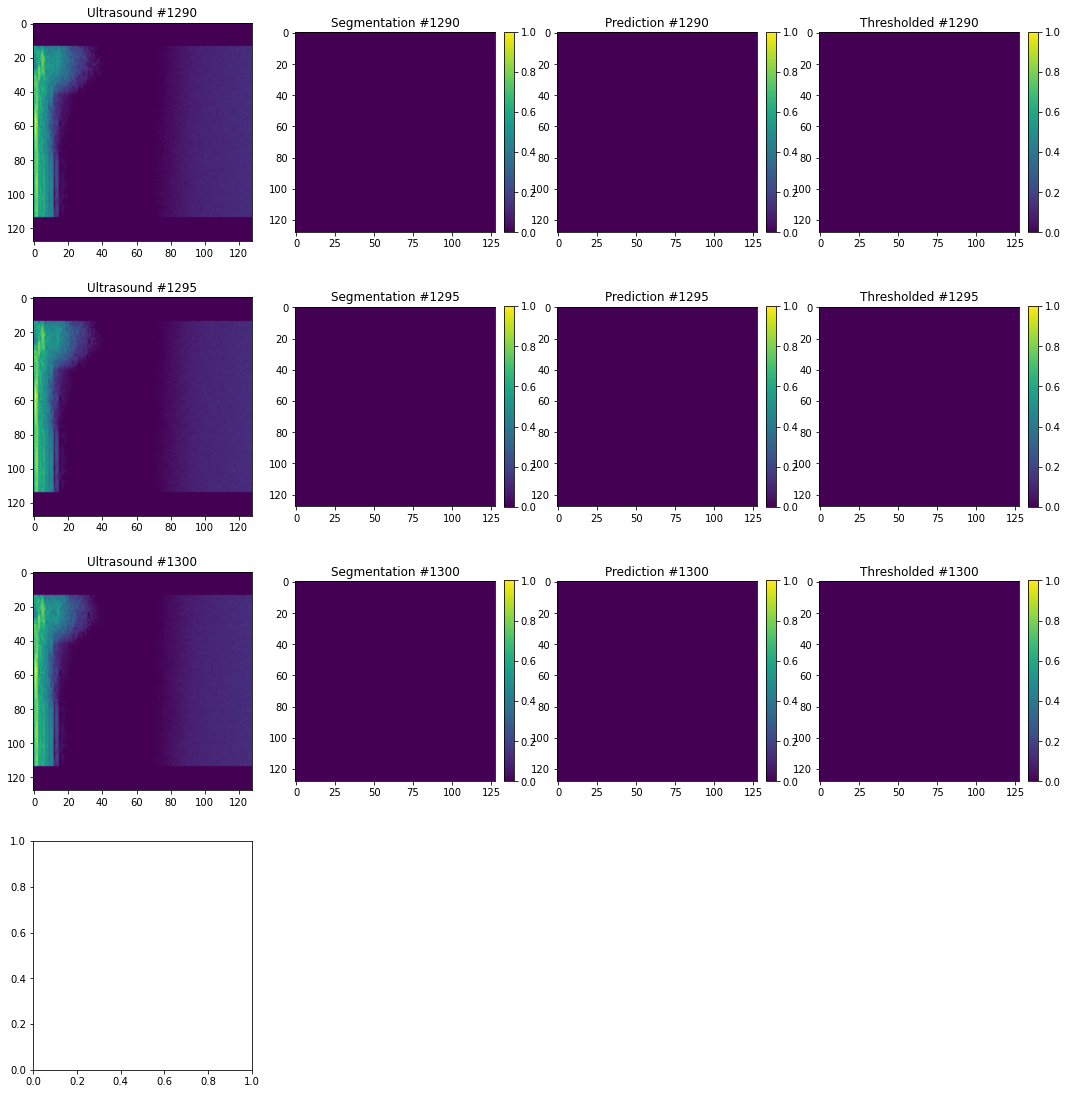

In [21]:
from random import sample
# num_vali = y_test.shape[0]
num_show = 17
num_col = 4
num_vali = 2200

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)
sample_indices = [1290,1295,1300]

threshold = 0.50

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(us_test[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(seg_test[sample_indices[i], :, :, 0]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(y_pred_test[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
    img3 = a3.imshow((np.flipud(y_pred_test[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
    c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    a3.set_title("Thresholded #{}".format(sample_indices[i]))

# Try loading previously trained model for metrics

In [ ]:
model_path_1 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\Logs_UNet_4\SavedModels\SagittalSpineSegmentationStudy-TF2_COPY_model-0_2020-11-22_23-29-57.h5"
model_path_2 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\Logs_UNet_4\SavedModels\SagittalSpineSegmentationStudy-TF2_COPY_model-1_2020-11-22_23-29-57.h5"
model_path_3 = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\Logs\Logs_UNet_4\SavedModels\SagittalSpineSegmentationStudy-TF2_COPY_model-2_2020-11-22_23-29-57.h5"

model_1 = unet.segmentation_unet(ultrasound_size, 2, filter_multiplier, regularization_rate)
model_2 = unet.segmentation_unet(ultrasound_size, 2, filter_multiplier, regularization_rate)
model_3 = unet.segmentation_unet(ultrasound_size, 2, filter_multiplier, regularization_rate)
model_1.load_weights(model_path_1)
model_2.load_weights(model_path_2)
model_3.load_weights(model_path_3)


In [ ]:
from pathlib import Path
import os
import numpy as np

input_dir_test = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\TestData"

seg_files_test = list(sorted(Path(input_dir_test).glob("*_segmentation.npy")))
us_files_test = list(sorted(Path(input_dir_test).glob("*_ultrasound.npy")))

seg_test_sequences = []
us_test_sequences = []
for i in range(len(seg_files_test)):
    seg_np = np.load(os.path.abspath(seg_files_test[i]))
    us_np = np.load(os.path.abspath(us_files_test[i]))
    
    seg_np = seg_np[...,np.newaxis] / 255
    us_np = us_np[...,np.newaxis] / 255
    
    seg_test_sequences.append(seg_np.transpose(2,1,0,3))
    us_test_sequences.append(us_np.transpose(2,1,0,3))

In [ ]:
seg_test_crossval = np.concatenate(seg_test_sequences, axis=0)
us_test_crossval = np.concatenate(us_test_sequences, axis=0)

In [ ]:
seg_test_crossval.shape

In [ ]:
us_test_crossval.shape

In [ ]:
# Predict on validation data
y_pred_test_model1  = model_1.predict(us_test_crossval)
y_pred_test_model2  = model_2.predict(us_test_crossval)
y_pred_test_model3  = model_3.predict(us_test_crossval)


In [ ]:
# Validation results
test_metrics_dicts_model1, test_best_threshold_index_model1, test_area_model1 = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_test_model1, seg_test_crossval, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
test_best_metrics_model1    = test_metrics_dicts_model1[test_best_threshold_index_model1]
test_auroc_model1         = test_area_model1
test_best_threshold_model1  = roc_thresholds[test_best_threshold_index_model1]

# Validation results
test_metrics_dicts_model2, test_best_threshold_index_model2, test_area_model2 = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_test_model2, seg_test_crossval, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
test_best_metrics_model2    = test_metrics_dicts_model2[test_best_threshold_index_model2]
test_auroc_model2         = test_area_model2
test_best_threshold_model2  = roc_thresholds[test_best_threshold_index_model2]


# Validation results
test_metrics_dicts_model3, test_best_threshold_index_model3, test_area_model3 = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_test_model3, seg_test_crossval, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
test_best_metrics_model3    = test_metrics_dicts_model3[test_best_threshold_index_model3]
test_auroc_model3         = test_area_model3
test_best_threshold_model3  = roc_thresholds[test_best_threshold_index_model3]


In [ ]:
# test_best_metrics_model1    = test_metrics_dicts_model1[test_best_threshold_index_model1]
test_best_metrics_model3    = test_metrics_dicts_model3[test_best_threshold_index_model3]
test_best_metrics_model2    = test_metrics_dicts_model2[test_best_threshold_index_model2]

In [ ]:
# Validation results
test_metrics_dicts_model1, test_best_threshold_index_model1, test_area_model1 = evaluation_metrics.compute_roc(
    roc_thresholds, y_pred_test_model1, seg_test_crossval, acceptable_margin_mm, mm_per_pixel)

#Record the best validation statistics
test_best_metrics_model1    = test_metrics_dicts_model1[test_best_threshold_index_model1]
test_auroc_model1         = test_area_model1
test_best_threshold_model1  = roc_thresholds[test_best_threshold_index_model1]


In [ ]:
test_best_metrics_model1

In [ ]:
test_best_metrics_model2

In [ ]:
test_best_metrics_model3

In [ ]:
iou = np.array([test_best_metrics_model1['jaccard'],
                test_best_metrics_model2['jaccard'],
                test_best_metrics_model3['jaccard']])

In [ ]:
iou.mean()

In [ ]:
iou.std()

In [ ]:
test_best_metrics_model1['jaccard']

In [ ]:
from random import sample
# num_vali = y_test.shape[0]
num_show = 20
num_col = 4
num_vali = 2200

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)
# sample_indices = [590, 600, 605, 610, 200, 150, 433]

threshold = 0.8

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(us_test_crossval[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(seg_test_crossval[sample_indices[i], :, :, 0]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(y_pred_test_model3[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
    img3 = a3.imshow((np.flipud(y_pred_test_model3[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
    c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    a3.set_title("Thresholded #{}".format(sample_indices[i]))